# Linear vortex panel method

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

In [2]:
# load geometry from data file
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

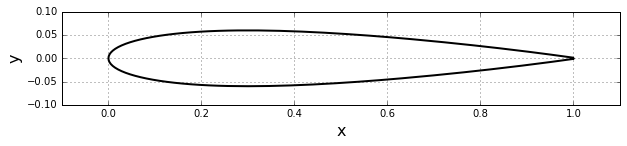

In [3]:
# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [5]:
def define_panels(x, y, N):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max()-x.min())/2.0        # circle radius
    x_center = (x.max()+x.min())/2.0 # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0*numpy.pi, N+1) # array of angles
    x_circle = x_center +  R*numpy.cos(theta)      # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)     # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends) # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

In [6]:
N = 100                            # number of panels
panels = define_panels(x, y, N)   # discretizes of the geometry into panels

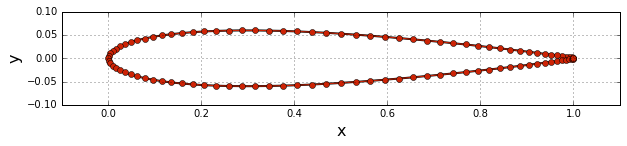

In [7]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

# Freestream Condition

In [12]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [9]:
# define and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

# Flow tangency boundary condition

In [10]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def integral_s(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( s*((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]